# Sampling with NUTS

Here we demonstrate how to sample with NUTS since we have access to the gradient.

The problem is suppose we have a mock observation, and the thermal electron field $n_e$ and cosmic ray electron distribution $C$ are all known. The $\mathbf{B}$ field is LSA model, but we do not know the correct parameter.

In this case, we will perform No-U-Turn Sampler (NUTS) to obtain the posterier for these parameter.

In this example we use **blackjax**, but there're more packages compatible with `JAX` ecosystem such as `numpyro` and `pyMC3`.

In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax,blackjax
jax.config.update("jax_enable_x64", True)
#sys.path.append('../synax/')

import synax,importlib
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
#for debug
def reload_package(package):
    importlib.reload(package)
    for attribute_name in dir(package):
        attribute = getattr(package, attribute_name)
        if type(attribute) == type(package):
            importlib.reload(attribute)
            
reload_package(synax)

## Construct mock observation

We construct a mock observation by adding a gaussian noise with std. 0.001 K to the simulated signal. This simulated signal is provided in `examples/` in the repo.

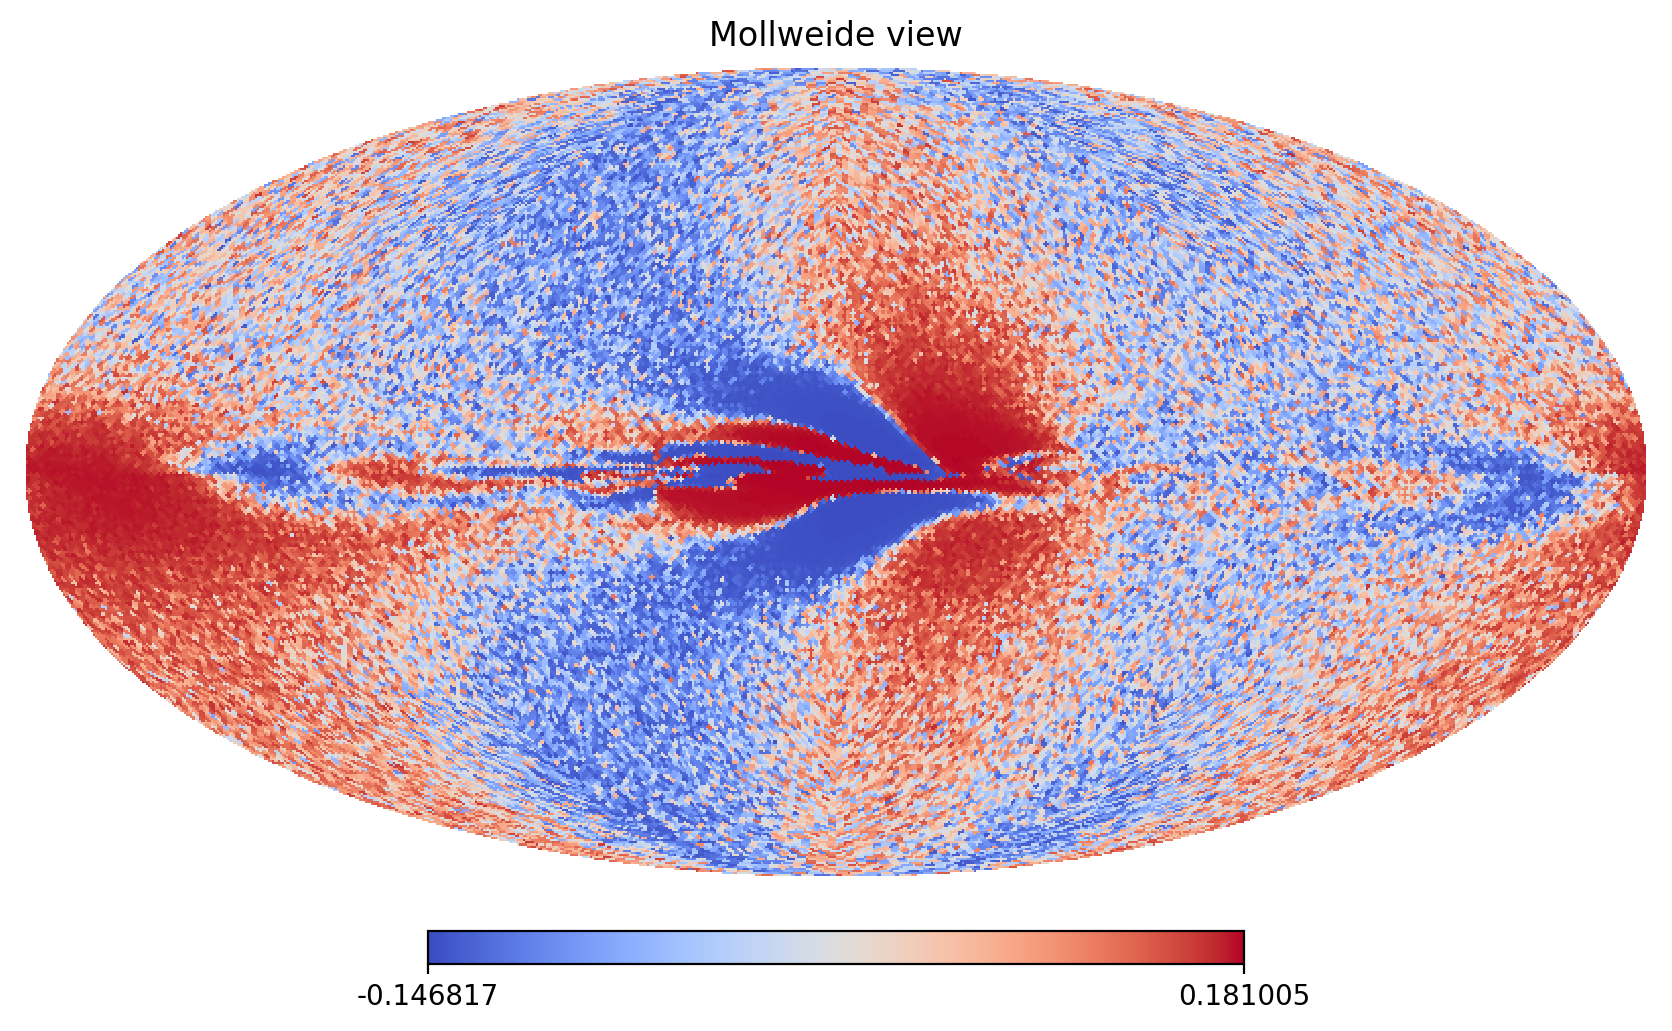

In [4]:
obs_maps = np.load('Sim_jf12.npy')
np.random.seed(42)
obs_Q = obs_maps[0] + np.random.randn(obs_maps[0].shape[0])*0.001
obs_U = obs_maps[1] + np.random.randn(obs_maps[0].shape[0])*0.001


hp.mollview(obs_Q,norm='hist',cmap='coolwarm')

## Set up coordinates and fields

During inference, there're some constant values such as the coordinates, $n_e$ fields and $C$ fields. We can pre calculate them to save some time during inference.

First let's generate the coordinates.

2024-09-14 21:33:27.691278: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(3, 49152, 512)

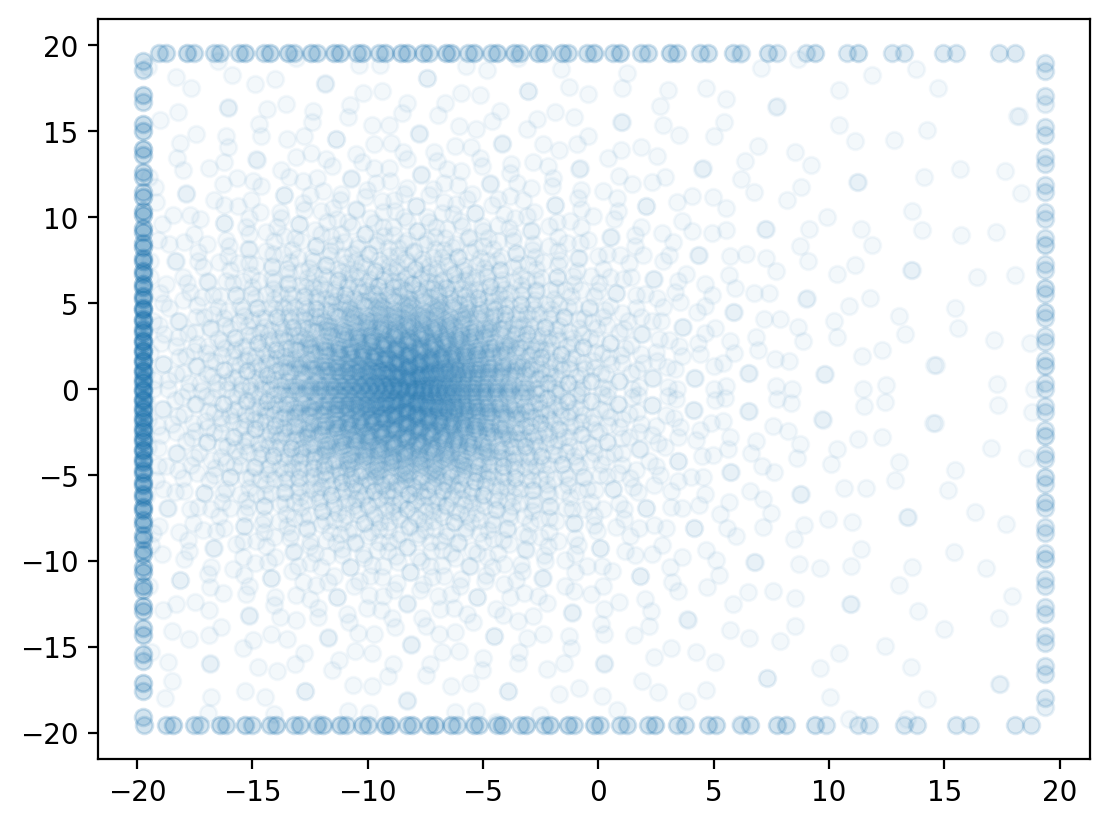

In [5]:
nside = 64
num_int_points = 512

poss,dls,nhats = synax.coords.get_healpix_positions(nside=nside,num_int_points=num_int_points)
plt.scatter(poss[0,::10,500],poss[1,::10,500],alpha=0.05)
poss.shape

Then generate C field, using the true model (WMAP model)

In [6]:
C_generator = synax.cfield.C_WMAP(poss)

C_field = C_generator.C_field()

Our $n_e$ field here is intepolated from a regular 3D field. This field is also provided in `examples/`

In [7]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [8]:
tereg = np.load('../examples/te.npy')

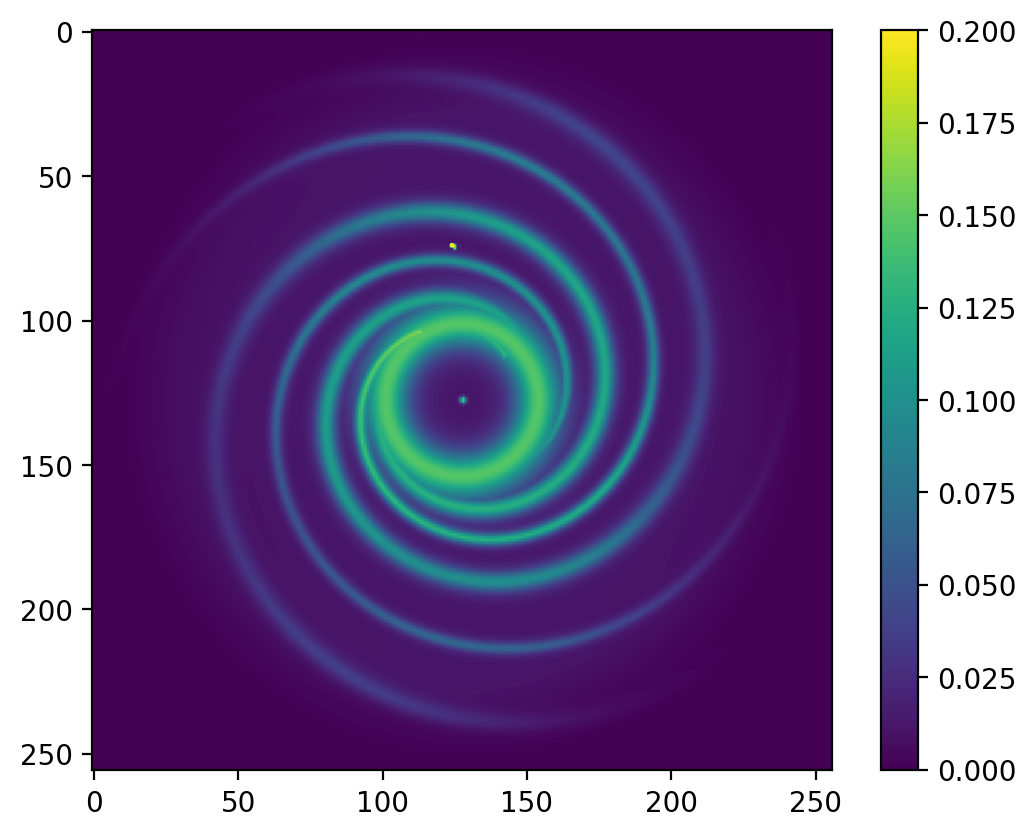

In [9]:
plt.imshow(tereg[:,:,32],vmax=0.2)
plt.colorbar()

In [10]:
TE_generator = synax.tefield.TE_grid(poss,(xs,ys,zs))

In [11]:
%%time
TE_field = TE_generator.TE_field(tereg)
TE_field.shape

CPU times: user 3 s, sys: 1.2 s, total: 4.2 s
Wall time: 4.23 s


(49152, 512)

## Carry out sampling

Now let's sample. The B field generator is also not a variable during inference, we can define one in advance.

In [12]:
jf12_params = {"b_arm_1":0.1,
               "b_arm_2":3.0,
               "b_arm_3":-0.9,
               "b_arm_4":-0.8,
               "b_arm_5":-2.0,
               "b_arm_6":-4.2,
               "b_arm_7":0.0,
               "b_ring":0.1,
               "h_disk":0.40,
               "w_disk":0.27,
               "bn":1.4,
               "bs":-1.1,
               "rn":9.22,
               "rs":16.7,
               "wh":0.20,
               "z0":5.3,
               "b0_x":4.6,
               "x_theta":49*np.pi/180,
               "rpc_x":4.8,
               "r0_x":2.9}

B_generator = synax.bfield.B_jf12(poss)
%time B_field = B_generator.B_field(jf12_params)
B_field.shape

CPU times: user 19 s, sys: 5.69 s, total: 24.7 s
Wall time: 13.1 s


(49152, 512, 3)

In [13]:
from datetime import date
rng_key = jax.random.key(42)
simer = synax.synax.Synax(sim_I = False)
freq = 2.4
spectral_index = 3.


Here we construct a likelihood. We first sim a map, then the likelihood reads,

$$
\log \mathcal{L} = \sum_i \left(\frac{(Q_i - Q_{i,\rm obs})^2}{2\sigma^2} + \frac{(U_i - U_{i,\rm obs})^2}{2\sigma^2}\right) + Constant
$$

We ignored this constant as it is not important.


In [14]:
@jax.jit
def jf12_model(jf12_params):


    B_field = B_generator.B_field(jf12_params)
    sync = simer.sim(freq,B_field,C_field,TE_field,nhats,dls,spectral_index)
    
    return sync['Q'],sync['U']

@jax.jit
def logdensity_fn(jf12_params):
    
    Sync_Q,Sync_U = jf12_model(jf12_params)

    return -1*jnp.sum(((Sync_Q-obs_Q)/0.001/2)**2) - jnp.sum(((Sync_U-obs_U)/0.001/2)**2)
value_grad = jax.value_and_grad(logdensity_fn)

I randomly choose a initial position.

In [15]:
initial_position = {"b_arm_1":0.2,
               "b_arm_2":6.0,
               "b_arm_3":-1.9,
               "b_arm_4":-1.8,
               "b_arm_5":-3.0,
               "b_arm_6":-2.2,
               "b_arm_7":1.0,
               "b_ring":1.1,
               "h_disk":1.40,
               "w_disk":1.27,
               "bn":0.4,
               "bs":-2.1,
               "rn":7.22,
               "rs":15.7,
               "wh":1.20,
               "z0":4.3,
               "b0_x":5.6,
               "x_theta":39*np.pi/180,
               "rpc_x":5.8,
               "r0_x":3.9}
%time value_grad(initial_position)
%time logdensity_fn(jf12_params)
%time logdensity_fn(initial_position)

2024-09-14 21:34:13.101032: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.35GiB (15405987929 bytes) by rematerialization; only reduced to 20.16GiB (21651653824 bytes), down from 20.16GiB (21651653824 bytes) originally


CPU times: user 24.4 s, sys: 6.1 s, total: 30.5 s
Wall time: 17.8 s
CPU times: user 22.6 s, sys: 6.31 s, total: 28.9 s
Wall time: 15.7 s
CPU times: user 14.4 ms, sys: 709 µs, total: 15.1 ms
Wall time: 14 ms


Array(-7376327.62884684, dtype=float64)

## blackjax
Some blackjax stuff. `blackjax.window_adaptation` will tune the parameters for NUTS. Let's run the tuning for 2000 iters.

In [ ]:
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity_fn)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
%time (state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=200)

In [ ]:
state, parameters

Copied from blackjax document: the sampling function.
Let's sample it for 500 iterations.

In [24]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

kernel = blackjax.nuts(logdensity_fn, **parameters,max_num_doublings = 8).step
%time states = inference_loop(sample_key, kernel, state, 500)

mcmc_samples = states.position

CPU times: user 5min 48s, sys: 32.2 s, total: 6min 20s
Wall time: 6min 14s


Trace plot, looks nice.

In [25]:
plt.plot(mcmc_samples["chi0"])

## numpyro

In [16]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

In [17]:
def model(obs_Q,obs_U):
    
    b_arm_1 = numpyro.sample("b_arm_1", dist.Uniform(-10,10))
    b_arm_2 = numpyro.sample("b_arm_2", dist.Uniform(-10,10))
    b_arm_3 = numpyro.sample("b_arm_3", dist.Uniform(-10,10))
    b_arm_4 = numpyro.sample("b_arm_4", dist.Uniform(-10,10))
    b_arm_5 = numpyro.sample("b_arm_5", dist.Uniform(-10,10))
    b_arm_6 = numpyro.sample("b_arm_6", dist.Uniform(-10,10))
    b_arm_7 = numpyro.sample("b_arm_7", dist.Uniform(-10,10))
    
    b_ring = numpyro.sample("b_ring", dist.Uniform(-2,2))
    h_disk = numpyro.sample("h_disk", dist.Uniform(-10,10))
    w_disk = numpyro.sample("w_disk", dist.Uniform(-10,10))
    
    #bn = numpyro.sample("bn", dist.Uniform(0,2))
    #bs = numpyro.sample("bs", dist.Uniform(-3,0))
    #rn = numpyro.sample("rn", dist.Uniform(0,10))
    #rs = numpyro.sample("rs", dist.Uniform(10,20))
    #wh = numpyro.sample("wh", dist.Uniform(0,2))
    
    #z0 = numpyro.sample("z0", dist.Uniform(0,10))
    #b0_x = numpyro.sample("b0_x", dist.Uniform(0,10))
    #x_theta = numpyro.sample("x_theta", dist.Uniform(0,2))
    #rpc_x = numpyro.sample("rpc_x", dist.Uniform(0,10))
    #r0_x = numpyro.sample("r0_x", dist.Uniform(0,5))
    
    '''model_params = {"b_arm_1":b_arm_1,
               "b_arm_2":b_arm_2,
               "b_arm_3":b_arm_3,
               "b_arm_4":b_arm_4,
               "b_arm_5":b_arm_5,
               "b_arm_6":b_arm_6,
               "b_arm_7":b_arm_7,
               "b_ring":b_ring,
               "h_disk":h_disk,
               "w_disk":w_disk,}
               #"bn":bn,
               #"bs":bs,
               #"rn":rn,
               #"rs":rs,
               #"wh":wh,
               #"z0":z0,
               #"b0_x":b0_x,
               #"x_theta":x_theta,
               #"rpc_x":rpc_x,
               #"r0_x":r0_x}'''
    model_params = {"b_arm_1":b_arm_1,
               "b_arm_2":b_arm_2,
               "b_arm_3":b_arm_3,
               "b_arm_4":b_arm_4,
               "b_arm_5":b_arm_5,
               "b_arm_6":b_arm_6,
               "b_arm_7":b_arm_7,
               "b_ring":b_ring,
               "h_disk":h_disk,
               "w_disk":w_disk,
               "bn":1.4,
               "bs":-1.1,
               "rn":9.22,
               "rs":16.7,
               "wh":0.20,
               "z0":5.3,
               "b0_x":4.6,
               "x_theta":49*np.pi/180,
               "rpc_x":4.8,
               "r0_x":2.9
                }
    #var_pol = numpyro.sample("kernel_varpol", dist.HalfNormal(jnp.ones(Y.shape[1])*var_pol_std))
    #length_pol = numpyro.sample("kernel_lengthpol", dist.Normal(jnp.ones(Y.shape[1])*length_pol_mean,jnp.ones(Y.shape[1])*length_pol_std))

    # compute kernel
    Sync_Q,Sync_U = jf12_model(model_params)
    
    
    numpyro.sample(
        "Sync_P",
        dist.Normal(jnp.array([Sync_Q,Sync_U]), 0.001),
        obs=jnp.array([obs_Q,obs_U]),
    )
    

In [18]:
initial_position = {"b_arm_1":0.2,
               "b_arm_2":6.0,
               "b_arm_3":-1.9,
               "b_arm_4":-1.8,
               "b_arm_5":-3.0,
               "b_arm_6":-2.2,
               "b_arm_7":1.0,
               "b_ring":1.1,
               "h_disk":1.40,
               "w_disk":1.27,}

init_strategy = init_to_value(
            values=initial_position
        )

kernel = NUTS(
        model,
        init_strategy=init_strategy,
        target_accept_prob=0.9,
        dense_mass=True,
        max_tree_depth=8)

mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=500,
    num_chains=1,
    thinning=1,
    progress_bar= True,
)

#mcmc.run() would do everything
mcmc.run(rng_key, obs_Q,obs_U)
mcmc.print_summary()


sample: 100%|██████████| 1000/1000 [11:35<00:00,  1.44it/s, 7 steps of size 2.55e-04. acc. prob=0.61] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_arm_1      0.24      0.13      0.28      0.04      0.38      2.53      2.54
   b_arm_2      3.14      0.06      3.16      3.05      3.22      2.39      3.01
   b_arm_3     -0.44      0.12     -0.40     -0.62     -0.29      2.43      2.81
   b_arm_4     -1.05      0.09     -1.08     -1.15     -0.92      2.44      2.76
   b_arm_5     -1.22      0.15     -1.17     -1.45     -1.05      2.54      2.52
   b_arm_6     -5.06      0.29     -5.16     -5.39     -4.62      2.49      2.63
   b_arm_7      0.64      0.06      0.61      0.57      0.73      2.62      2.35
    b_ring      0.08      0.01      0.08      0.07      0.10      2.37      3.09
    h_disk      1.76      0.80      1.42      0.98      3.01      2.77      2.13
    w_disk      1.67      0.77      1.34      0.91      2.88      2.76      2.14

Number of divergences: 35


In [ ]:
jf12_params = {"b_arm_1":0.1,
               "b_arm_2":3.0,
               "b_arm_3":-0.9,
               "b_arm_4":-0.8,
               "b_arm_5":-2.0,
               "b_arm_6":-4.2,
               "b_arm_7":0.0,
               "b_ring":0.1,
               "h_disk":0.40,
               "w_disk":0.27,}

## Post analysis

First let's draw the posterior. Apparently we get the true answer.

In [21]:
from getdist import plots, MCSamples
names = initial_position.keys()
labels = names
samps = np.array([mcmc_samples[names[i]] for i in range(4)]).T
samples = MCSamples(samples=samps,names = names, labels = labels)


Removed no burn in


Text(0.88, 0.88, 'Noise RMS = 1mK')

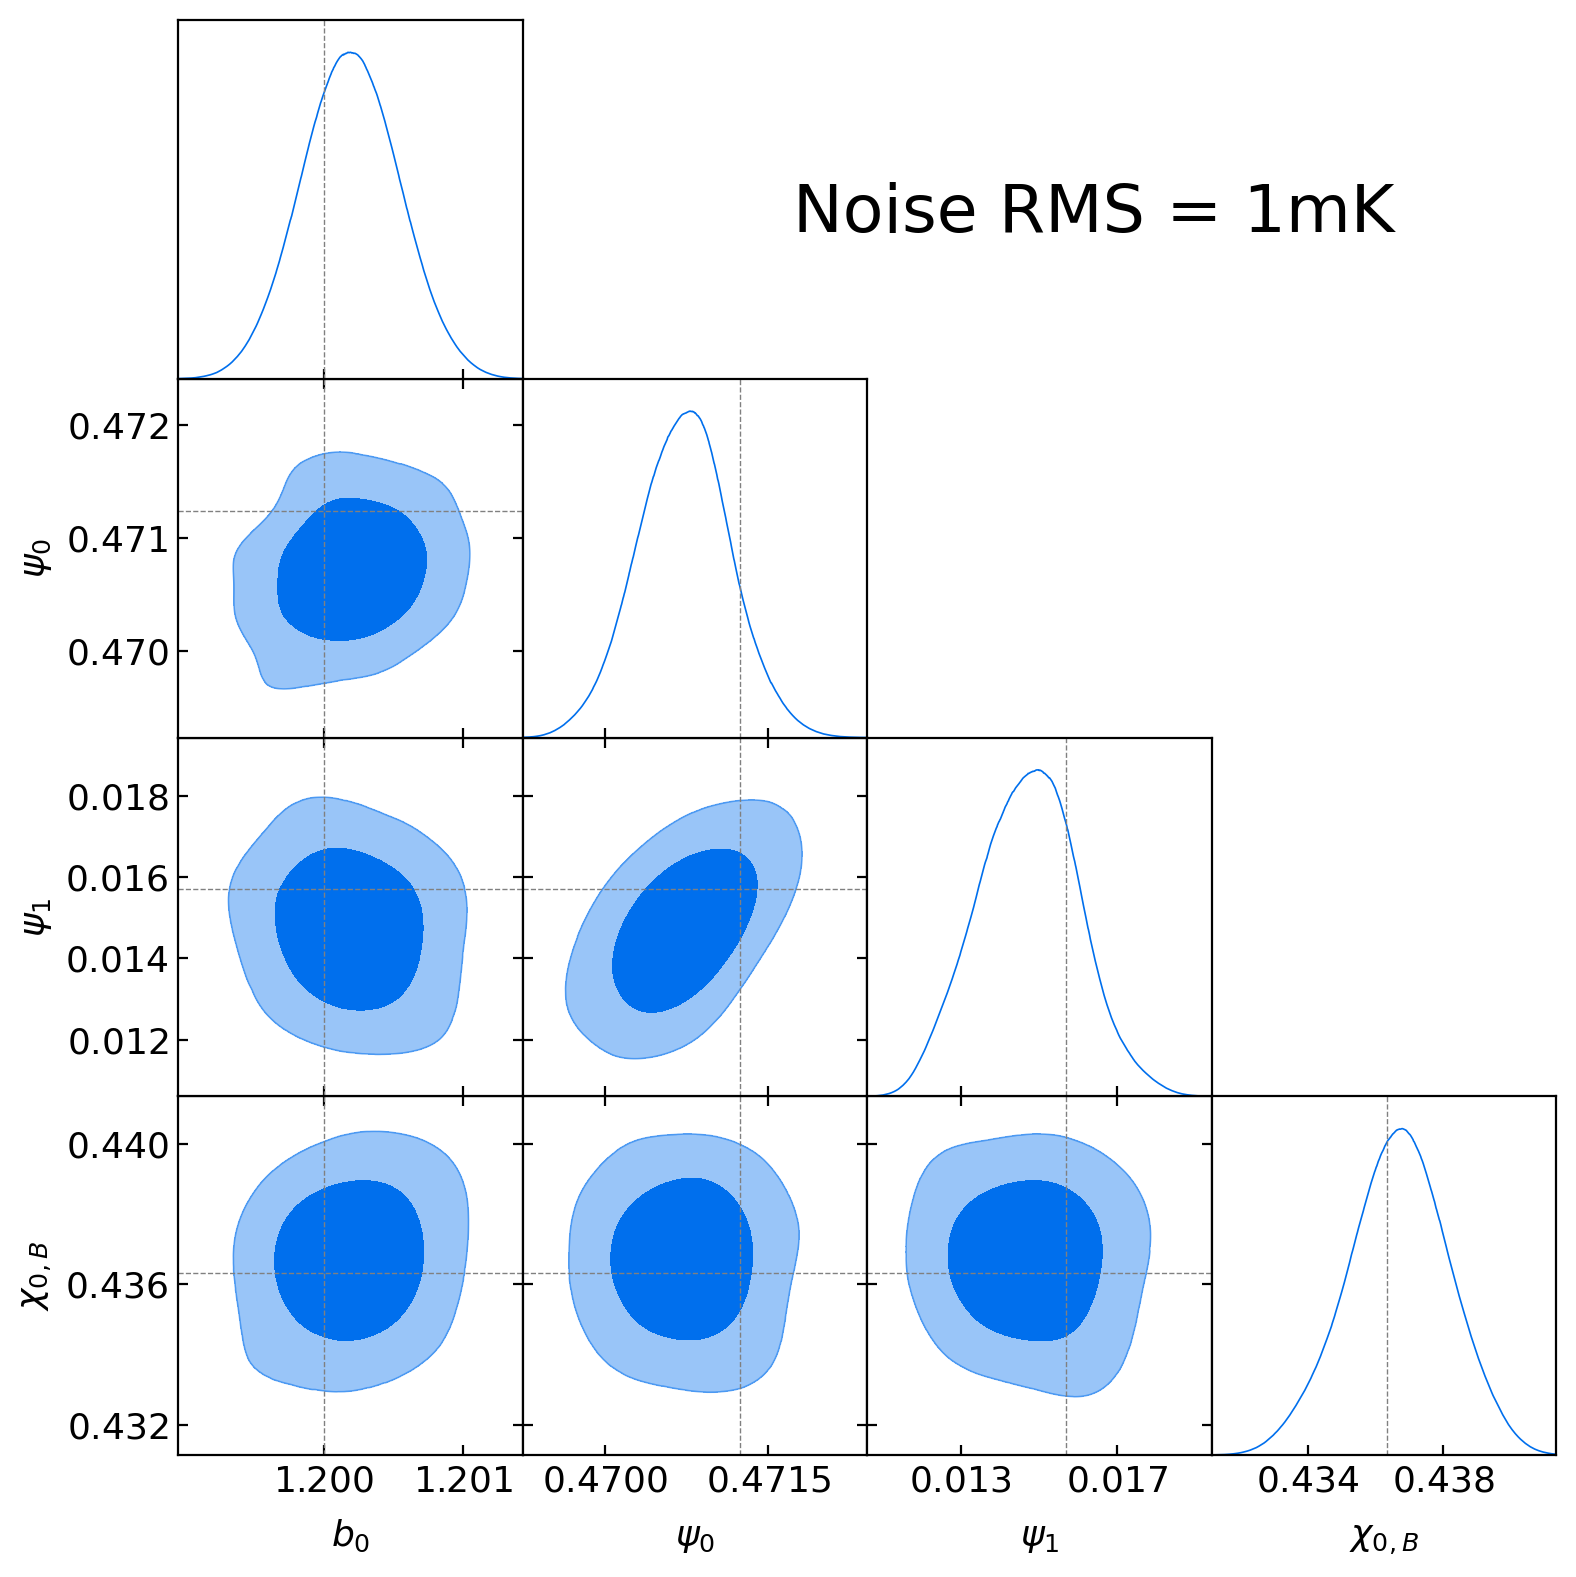

In [29]:
%matplotlib inline

true_params = jf12_params
g = plots.get_subplot_plotter(rc_sizes=20)
g.settings.lab_fontsize = 16
g.settings.axes_fontsize = 16
g.triangle_plot([samples],names, filled=True,markers=true_params)
plt.suptitle('Noise RMS = 1mK',x=0.88,y=0.88,ha='right',va='top',fontsize = 24)
#plt.suptitle('Noise RMS = 1mK',va = 'bottom',fontsize = 20);
#plt.savefig('../figures/posterior_lsa_1mk.pdf',dpi=500,bbox_inches='tight')

This is the $\hat{r}$ to verify the convergence. We're very converged!

In [22]:
[blackjax.diagnostics.potential_scale_reduction(samps.T[i].reshape([4,-1])) for i in range(4)]

[Array(1.00035458, dtype=float64),
 Array(1.00266913, dtype=float64),
 Array(1.00216394, dtype=float64),
 Array(1.00098933, dtype=float64)]

ESS also have the same order of magnitude as sampling iterations. 

In [23]:
[blackjax.diagnostics.effective_sample_size(samps.T[i].reshape([4,-1])) for i in range(4)]

[Array(683.00025544, dtype=float64),
 Array(447.13332335, dtype=float64),
 Array(276.4008167, dtype=float64),
 Array(193.83849754, dtype=float64)]

Here is the std and accuracy for each parameter.

In [25]:
for name in names:
    acc = np.mean(mcmc_samples[name])/true_params[name]
    print(name+" acc:" + str(1-acc))
    acc = np.mean(mcmc_samples[name])
    print(name+" mean:" + str(acc))
    acc = np.percentile(mcmc_samples[name],[16,84]) - np.mean(mcmc_samples[name])
    print(name+" std:" + str(acc[0])+", "+str(acc[1]))

b0 acc:-0.0001738643826538766
b0 mean:1.2002086372591845
b0 std:-0.0003372701586705773, 0.0003392296976092446
psi0 acc:0.0011506644537284672
psi0 mean:0.4706966601892819
psi0 std:-0.0004436898594020744, 0.0003889098435341798
psi1 acc:0.06484060577279827
psi1 mean:0.014689449414198292
psi1 std:-0.0011748403015462167, 0.001154116877975028
chi0 acc:-0.0008735126447161345
chi0 mean:0.43671345479128487
chi0 std:-0.001444809572399064, 0.0014276393331947301
